In [124]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [125]:
#Importing data refining modules
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

#Importing Classifying Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn import svm
#Performance measuring modules
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score

In [126]:
data = pd.read_csv('heart.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [127]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [128]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


No null values

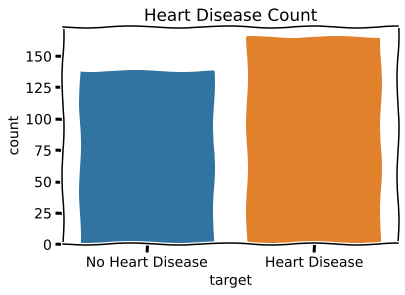

In [129]:
sns.countplot(x='target' ,data=data)
plt.xticks([0,1], ['No Heart Disease', 'Heart Disease'])
plt.title('Heart Disease Count')
plt.show()

Almost balanced data

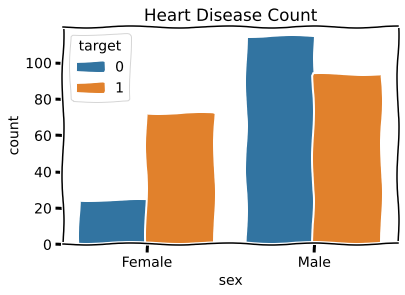

In [130]:
sns.countplot(x='sex', data = data, hue='target')
plt.xticks([0,1], ['Female', 'Male'])
plt.title('Heart Disease Count')
plt.show()

Mens are likely to have heart disease slightly more.

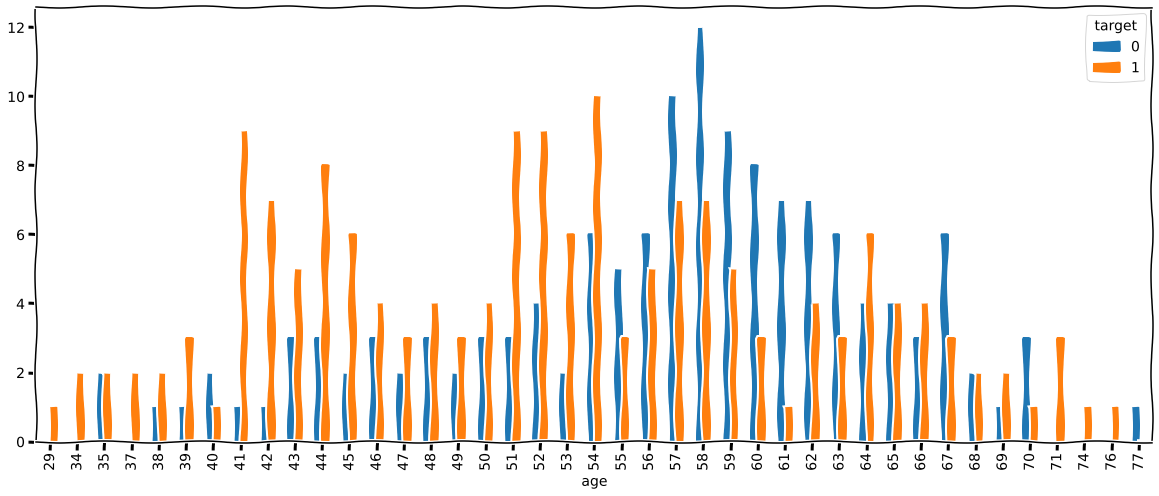

In [131]:
pd.crosstab(data.age, data.target).plot(kind='bar', figsize=(20,8))

There are significantly more people with heart disease from age 37 to 54 than in other age group.


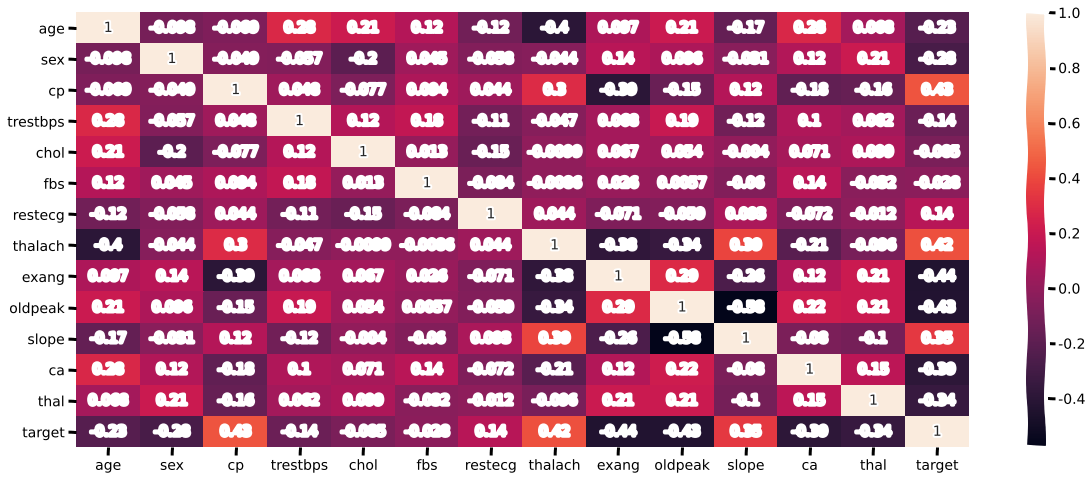

In [132]:
_, axs = plt.subplots(figsize=(20,8))
sns.heatmap(data=data.corr(), annot=True)

# Features with Correlation > 0.3 with target


1.   Thal
2.   CA
3.   slope
4.   oldpeak
5.   exang
6.   thalach
7.   cp


In [133]:
data.corr().shape

(14, 14)

##Making a feature filter

In [134]:
#Returns filtered dataframe with features having correlation with target > threshold value
corr_threshold = 0.2
def featureFilter(data = None, corr_threshold = 0.3):
  selected_features = []
  for i in range(len(data.columns)-1):
    if abs(data[data.columns[i]].corr(data['target'])) > corr_threshold:
      selected_features.append(data.columns[i])
  new_data = pd.DataFrame()
  for i in selected_features:
    new_data[i] = data[i]
  return new_data

new_data = featureFilter(data, corr_threshold = corr_threshold)
new_data

,age,sex,cp,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,150,0,2.3,0,0,1
1,37,1,2,187,0,3.5,0,0,2
2,41,0,1,172,0,1.4,2,0,2
3,56,1,1,178,0,0.8,2,0,2
4,57,0,0,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...
298,57,0,0,123,1,0.2,1,0,3
299,45,1,3,132,0,1.2,1,0,3
300,68,1,0,141,0,3.4,1,2,3
301,57,1,0,115,1,1.2,1,1,3


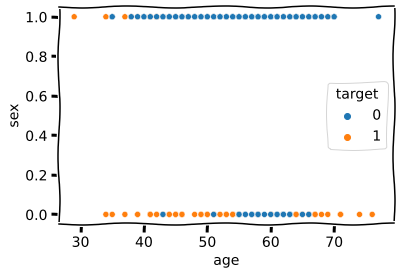

In [135]:
sns.scatterplot(x='age', y='sex', data=data, hue='target')

Now Encoding the features


In [136]:
x = new_data.iloc[:, :].values
y = data['target'].values

#convert_to_categorical = ColumnTransformer([('encoder', OneHotEncoder(), [i for i in range(7)])], remainder = 'passthrough')
#x_converted = convert_to_categorical.fit_transform(x)
x.shape

(303, 9)

In [137]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
X_train.shape

(212, 9)

Now Scaling the features


##Trying Logistic Regression


In [138]:
#Training Model
lModel = LogisticRegression(max_iter=500)
lModel.fit(X_train, y_train)

#Predicting
predictedVals = lModel.predict(X_train)


#Testing with test data
predictedTestVals = lModel.predict(X_test)

print("Training Data's Confusion Matrix:\n", confusion_matrix(y_train, predictedVals))
print("Testing Data\'s Confusion Matrix:\n", confusion_matrix(y_test, predictedTestVals))
print('\nTraining Data\'s Accuracy Score: ', accuracy_score(y_train, predictedVals))
print('Testing Data\'s Accuracy Score: ', accuracy_score(y_test, predictedTestVals))


Training Data's Confusion Matrix:
 [[ 78  22]
 [ 11 101]]
Testing Data's Confusion Matrix:
 [[30  8]
 [ 5 48]]

Training Data's Accuracy Score:  0.8443396226415094
Testing Data's Accuracy Score:  0.8571428571428571


Hmm, pretty good result we've got here but it's overfitted. Let's try other models as well.

##Trying KNN Classifier


In [139]:
new_data = featureFilter(data, corr_threshold=0.3)

x=new_data.iloc[:,:]
y=data['target']

#Lets Scale data
scalar = StandardScaler()
x = scalar.fit_transform(x)


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
X_train.shape

(212, 7)

In [140]:
#Train
kClassifier = KNeighborsClassifier(n_neighbors = 20)
kClassifier.fit(X_train, y_train)

predictedVals = kClassifier.predict(X_train)
predictedTestVals = kClassifier.predict(X_test)

print("Training Data's Confusion Matrix:\n", confusion_matrix(y_train, predictedVals))
print("Testing Data\'s Confusion Matrix:\n", confusion_matrix(y_test, predictedTestVals))

print('\nTraining Data\'s Accuracy Score: ', accuracy_score(y_train, predictedVals))
print('Testing Data\'s Accuracy Score: ', accuracy_score(y_test, predictedTestVals))

Training Data's Confusion Matrix:
 [[ 78  19]
 [  9 106]]
Testing Data's Confusion Matrix:
 [[27 14]
 [ 4 46]]

Training Data's Accuracy Score:  0.8679245283018868
Testing Data's Accuracy Score:  0.8021978021978022


Hmm, better than LogisticRegression. Cool, it's performed with test data better than training data. But it could be due to luck while splitting the train-test data.
Now, let's try Decision Tree Classifier

##Trying Decision Tree Classifier

In [141]:
new_data = featureFilter(data, corr_threshold=0.3)

x = new_data.iloc[:,:]
y = data['target']

x = scalar.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
X_train.shape

(212, 7)

In [142]:
def parametersTuner(split = 2, leaf = 1, diff_threshold = 0.2):
  '''
    Params:
      split: (integer) 
      leaf: (integer)
    Returns: The best decision tree with optimal value of two parameters: min_sample_leaf and min_sample_split
  '''
  performanceRecord = {}    #ClassifierObject : (trainScore, testScore)
  for splitVar in range(2, split):
    for leafVar in range(1, leaf):

      #First instantiate a classifier object
      treeClassifier = DecisionTreeClassifier(min_samples_split=splitVar, min_samples_leaf = leafVar)

      #Then Train the classifier with the specified test parameters
      treeClassifier.fit(X_train, y_train)

      #Predict
      predictedVals = treeClassifier.predict(X_train)
      predictedTestVals = treeClassifier.predict(X_test)

      #Measure Accuracy
      trainScore = accuracy_score(y_train, predictedVals)
      testScore = accuracy_score(y_test, predictedTestVals)

      #Store the classifier and it's performance in dict object if the variance is inside acceptable range
      if abs(trainScore-testScore) <= diff_threshold and trainScore > 0.5 and testScore > 0.5:
        performanceRecord[treeClassifier] = (trainScore, testScore)

  #Sort the preformanceRecord in decending order with respect to testing accuracy
  performanceRecord = {k:v for k,v in sorted(performanceRecord.items(), key = lambda item: item[1])}

  #for k,v in performanceRecord.items():
   # print('\nClassifier: ', "\nAccuracy: ", v[1], "\nDifference: ", abs(v[0]-v[1]))                     
  #Compare performance of each classifier stored
  #Rules of optimal tree:
    #-> Least distance between test and train data prediction
    #-> Highest Accuracy
  optimalModel = {DecisionTreeClassifier() : (math.inf, 0)}     #ClassifierObject : (trainScore, testScore)
  for key, val in performanceRecord.items():
      if abs(val[0]-val[1]) < abs(optimalModel[next(iter(optimalModel))][0]-optimalModel[next(iter(optimalModel))][1]):
        optimalModel = {key: val}
  return optimalModel

optimalModel = parametersTuner(split = 9, leaf = 2, diff_threshold = 0.15)
trainScore = next(iter(optimalModel.values()))[0]
testScore = next(iter(optimalModel.values()))[1]

optimalModel = next(iter(optimalModel.keys()))

print('\nTraining Data\'s Accuracy Score: ', trainScore)
print('Testing Data\'s Accuracy Score: ', testScore)
print("Selected Model: ", optimalModel)


Training Data's Accuracy Score:  0.9198113207547169
Testing Data's Accuracy Score:  0.7912087912087912
Selected Model:  DecisionTreeClassifier(min_samples_split=8)


Highly Overfitted. But at least it is what it is and it is what was expected of this model. Now lets try Random Forest to improve the accuracy.

##Trying Random Forest

In [143]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.3)
randClassifier = RandomForestClassifier(n_estimators=15, criterion='entropy', max_depth=5)

randClassifier.fit(X_train, y_train)

predictedVals = randClassifier.predict(X_train)
predictedTestVals = randClassifier.predict(X_test)

print("Training Data's Confusion Matrix:\n", confusion_matrix(y_train, predictedVals))
print("Testing Data\'s Confusion Matrix:\n", confusion_matrix(y_test, predictedTestVals))

print('\nTraining Data\'s Accuracy Score: ', accuracy_score(y_train, predictedVals))
print('Testing Data\'s Accuracy Score: ', accuracy_score(y_test, predictedTestVals))

Training Data's Confusion Matrix:
 [[ 84  14]
 [  4 110]]
Testing Data's Confusion Matrix:
 [[30 10]
 [ 4 47]]

Training Data's Accuracy Score:  0.9150943396226415
Testing Data's Accuracy Score:  0.8461538461538461


I don't know why but the accuracy is fluctuating everytime I train model.
Oh, I know why, it's the same with previous models because of the random train-test split of the data. 
Lets graph the fluctuating prediction accuracy.

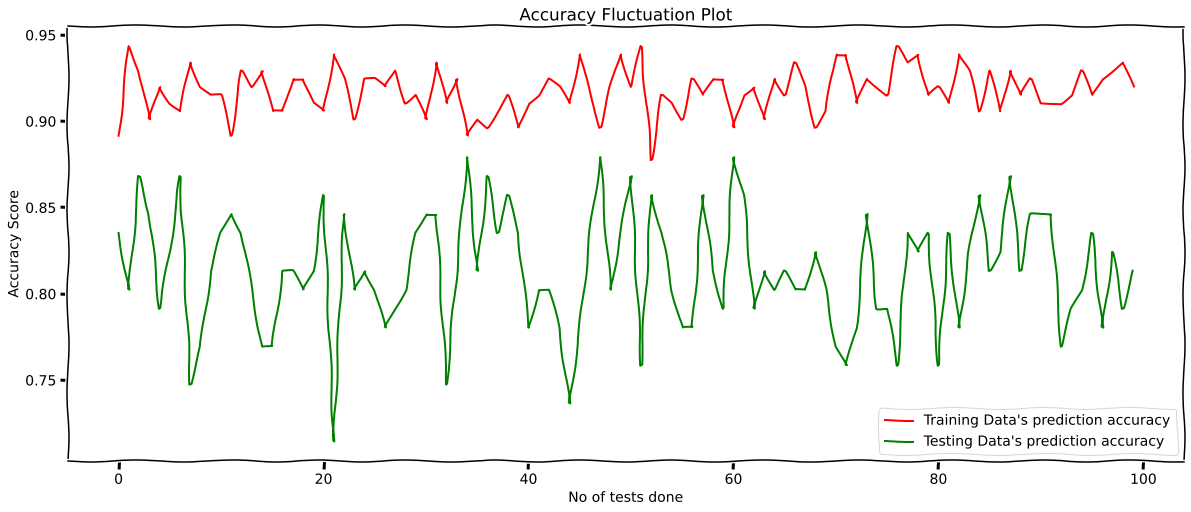

In [144]:
no_of_test = 100
train_accuracy = []
test_accuracy = []
for i in range(no_of_test):
  X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.3)
  randClassifier = RandomForestClassifier(n_estimators=15, criterion='entropy', max_depth=5)

  randClassifier.fit(X_train, y_train)

  train_accuracy.append(accuracy_score(y_train, randClassifier.predict(X_train)))
  test_accuracy.append(accuracy_score(y_test, randClassifier.predict(X_test)))
_, axs = plt.subplots(figsize=(20,8))
plt.title("Accuracy Fluctuation Plot")
#plt.xkcd()        #Comic style I find cool
plt.plot(train_accuracy, color='red', label='Training Data\'s prediction accuracy')
plt.plot(test_accuracy, color='green', label='Testing Data\'s prediction accuracy')
plt.xlabel("No of tests done")
plt.ylabel("Accuracy Score")
plt.grid()
plt.legend()

Looking at the graph it seems like the fluctuating accuracies are sometimes soo good that it has perfectly optimized hyperparameters but sometimes the model is overfitted.

In [145]:
print("Min training accuracy: ", min(train_accuracy))
print("Max training Accuracy: ", max(train_accuracy))
print("Min Testing Accuracy: ", min(test_accuracy))
print("Max Testing accuracy: ", max(test_accuracy))

max_training_deviation = 0
min_training_deviation = math.inf
for i in range(len(train_accuracy)):
  if max_training_deviation < abs(train_accuracy[i]-test_accuracy[i]):
    max_training_deviation = abs(train_accuracy[i]-test_accuracy[i])
  if min_training_deviation > train_accuracy[i]-test_accuracy[i]:
    min_training_deviation = train_accuracy[i]-test_accuracy[i]
  

print("\nMax Accuracy Deviation: ", max_training_deviation)
print("Min Accuracy Deviation: ", min_training_deviation)       #Negative sign indicates the testing data performed better with the model than training

Min training accuracy:  0.8773584905660378
Max training Accuracy:  0.9433962264150944
Min Testing Accuracy:  0.7142857142857143
Max Testing accuracy:  0.8791208791208791

Max Accuracy Deviation:  0.22439353099730452
Min Accuracy Deviation:  0.012388554841385013


**Let's try Bagging with different models**

In [146]:
classifierList = [LogisticRegression(), DecisionTreeClassifier(), KNeighborsClassifier(), RandomForestClassifier()]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

def bestClassifier(givenModelList = [LogisticRegression()], deviationThreshold = 0.2):
    '''
        This function will select the best performing model among the given models with bagging algorithm.
        Unfortunately it cannot select those by tuning their parameter weights, so, yeah, sorry.
        Params: 
            givenModelList: List
    '''
    performanceRecord = {}   #Formet: {Model: (train accuracy, test accuracy, deviation)}
    
    #Test every model and record their performance
    est=10
    for model in givenModelList:
        #Make a model
        bagger = BaggingClassifier(base_estimator = model, n_estimators = est)

        #Training
        bagger.fit(X_train, y_train)

        #Predicting
        predictedVals = bagger.predict(X_train)
        predictedTestVals = bagger.predict(X_test)

        #Measuring test-train accuracy
        train_accuracy = accuracy_score(y_train, predictedVals)
        test_accuracy = accuracy_score(y_test, predictedTestVals)
        
        #Record the performance
        performanceRecord[bagger] = (train_accuracy, test_accuracy, train_accuracy-test_accuracy)
        
    
    sortedRecord = {k:v for k,v in sorted(performanceRecord.items(), key = lambda items: items[1][1], reverse=True)}
    
    #Select the model with best preformance
    #Performance Better means with high test accuracy and less deviation
    bestTillNow = {None: (0, 0, math.inf)}
    
    for k,v in sortedRecord.items():
        if v[2] <= deviationThreshold:
            bestTillNow = {k: v}
            break
        else:
            try:
                if next(iter(bestTillNow))[2] > v[2]:
                    bestTillNow = {k: v}
            except TypeError:
                print("No model gave any result with that deviation threshold. It's too small.")
                return None, None
    return bestTillNow, sortedRecord
    
bestClassifier, record = bestClassifier(givenModelList = classifierList, deviationThreshold = 0.1)
bestClassifier

{BaggingClassifier(base_estimator=LogisticRegression()): (0.8207547169811321,
  0.8791208791208791,
  -0.05836616213974699)}

In [147]:
print('Best Bagging Classifier: ', next(iter(bestClassifier.keys())))
accuracy = bestClassifier[next(iter(bestClassifier.keys()))]

print('Training Accuracy: ', accuracy[0])
print('Testing Accuracy: ', accuracy[1])
print('Deviation: ', accuracy[2])

Best Bagging Classifier:  BaggingClassifier(base_estimator=LogisticRegression())
Training Accuracy:  0.8207547169811321
Testing Accuracy:  0.8791208791208791
Deviation:  -0.05836616213974699


Negative deviation means that the training accuracy is lower than testing.

**Now time for some Boostins**

In [148]:
gBooster = GradientBoostingClassifier(learning_rate = 0.01, n_estimators = 100, max_depth = 3)

gBooster.fit(X_train, y_train)

%timeit predictedVals = gBooster.predict(X_train)
predictedTestVals = gBooster.predict(X_test)

print("Training Data's Confusion Matrix:\n", confusion_matrix(y_train, predictedVals))
print("Testing Data\'s Confusion Matrix:\n", confusion_matrix(y_test, predictedTestVals))

print('\nTraining Data\'s Accuracy Score: ', accuracy_score(y_train, predictedVals))
print('Testing Data\'s Accuracy Score: ', accuracy_score(y_test, predictedTestVals))

576 µs ± 4.36 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Training Data's Confusion Matrix:
 [[46 50]
 [42 74]]
Testing Data's Confusion Matrix:
 [[36  6]
 [ 6 43]]

Training Data's Accuracy Score:  0.5660377358490566
Testing Data's Accuracy Score:  0.8681318681318682


In [149]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

aBooster = AdaBoostClassifier(base_estimator = LogisticRegression(), learning_rate = 0.01, n_estimators = 100, algorithm = 'SAMME.R')

aBooster.fit(X_train, y_train)

predictedVals = aBooster.predict(X_train)
predictedTestVals = aBooster.predict(X_test)

print("Training Data's Confusion Matrix:\n", confusion_matrix(y_train, predictedVals))
print("Testing Data\'s Confusion Matrix:\n", confusion_matrix(y_test, predictedTestVals))

print('\nTraining Data\'s Accuracy Score: ', accuracy_score(y_train, predictedVals))
print('Testing Data\'s Accuracy Score: ', accuracy_score(y_test, predictedTestVals))

Training Data's Confusion Matrix:
 [[ 63  29]
 [  4 116]]
Testing Data's Confusion Matrix:
 [[32 14]
 [ 4 41]]

Training Data's Accuracy Score:  0.8443396226415094
Testing Data's Accuracy Score:  0.8021978021978022


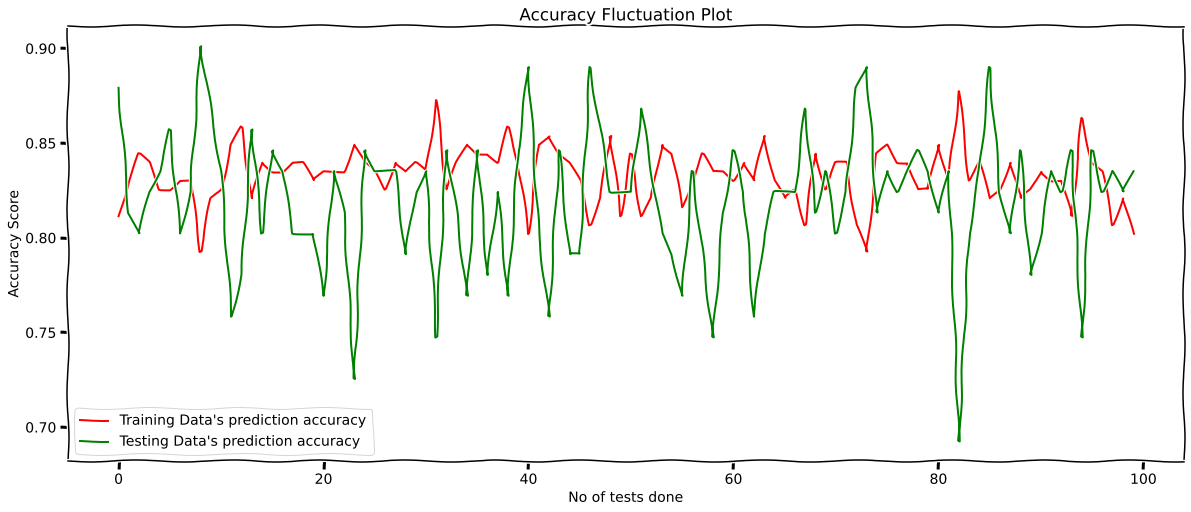

In [150]:
no_of_tests = 100
trAccuracyHistory = []
teAccuracyHistory = []

for i in range(no_of_tests):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

    aBooster = AdaBoostClassifier(base_estimator = LogisticRegression(), learning_rate = 0.01, n_estimators = 100, algorithm = 'SAMME.R')

    aBooster.fit(X_train, y_train)

    predictedVals = aBooster.predict(X_train)
    predictedTestVals = aBooster.predict(X_test)
    
    trAccuracyHistory.append(accuracy_score(y_train, predictedVals))
    teAccuracyHistory.append(accuracy_score(y_test, predictedTestVals))

_, axs = plt.subplots(figsize=(20,8))    
plt.title("Accuracy Fluctuation Plot")
#plt.xkcd()        #Comic style I find cool
plt.plot(trAccuracyHistory, color='red', label='Training Data\'s prediction accuracy')
plt.plot(teAccuracyHistory, color='green', label='Testing Data\'s prediction accuracy')
plt.xlabel("No of tests done")
plt.ylabel("Accuracy Score")
plt.grid()
plt.legend()

Look at those fluctuations. Man, this is crazy. I seriously need more data for some consistancy here.

**Using SVM**